# In this Notebook, my implementation of the recommending algorithm will be running
I am born in november, so the main focus will be on Data Analysis the second one on explainability and performance will be more or less irrelevant.



### In the first Cell we can find all necessary imports


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print('imports done!')

imports done!


The Movielens Dataset, which is to be used, has been downloaded and added to the repository to get a maximised usability on every possible platform. Therefore, the only thing that has to be defined is the path to the data, so it can get loaded and be used for Data Analysis and recommending purposes.

In [3]:
movielens_dir = Path.cwd() / "ml-100k"

# print(movielens_dir)

Additionally we will need the United States Zip Codes for our geographical analysis.
It is also already part of the repo, so there will be no problem of using it.

In [4]:
zip_code_cols = ['zip_code','type','decommissioned','primary_city','acceptable_cities','unacceptable_cities','state','county','timezone','area_codes','world_region','country','latitude','longitude','irs_estimated_population']
zip_code_dir = Path.cwd() / "zip_code_database.csv"
zip_codes_df = pd.read_csv(zip_code_dir, sep = ',', names= zip_code_cols, encoding='latin-1')
zip_codes_df.drop([0], inplace = True)
zip_codes_df.drop(['type','decommissioned','primary_city','acceptable_cities','unacceptable_cities','county','timezone','area_codes','world_region','country','latitude','longitude','irs_estimated_population'], axis = 1, inplace = True)
zip_codes_df['zip_code'] = zip_codes_df['zip_code'].astype('int64')

#print(zip_codes_df.head(20))
#zip_codes_df.dtypes


## Reading and Preprocessing

All the data is read by using the pandas.read_csv function and loaded into a dataframe, the columns of each type of information is linked with their Keywords. If we do not need some data we will simply drop them to get a better handling for the dataframes. Also we change some datatypes

The movie-attribute "release_date" however has most times just the first of january as its date, so it can (and should for validity reasons) be stripped down to just the year.

In [5]:
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv(movielens_dir / "u.user", sep='|', names=user_cols,encoding='latin-1')
print('users done, onto ratings now')

ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(movielens_dir / "u.data", sep='\t', names=ratings_cols)
#print(ratings.head())
ratings.drop(['timestamp'], axis=1, inplace=True)
#print(ratings.head())
print('ratings done, onto movies now')

movie_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance','Sci_Fi','Thriller','War','Western']
movies = pd.read_csv(movielens_dir / "u.item", sep='|', names=movie_cols, encoding='latin-1')
movies.drop(['IMDb_URL','video_release_date'], axis=1, inplace=True)
movies['release_date'] = pd.to_datetime(movies['release_date'])
movies['release_date'] = movies['release_date'].dt.year
movies.iloc[:, 3:] = movies.iloc[:, 3:].astype(bool)
#movies.sort_values(by='release_date', inplace=True)
#print(movies.head(10))
movie_ratings = pd.merge(movies, ratings)
df_proto = pd.merge(movie_ratings, users)
df_proto.drop(['zip_code'], axis=1, inplace=True)
print('all done and merged')
#print(df_all.dtypes)

users done, onto ratings now
ratings done, onto movies now
all done and merged


## Data Analysis on Geography:

To analyze whether the location of users is equally distributed in the United States, the user-dataframe is plotted onto the zip-codes-to-state-dataframe which distribution is then plotted as the following pie chart.

As shown below, we can say that the distribution among the States the users live in correlates with the population of the US in 1998, with the exception that Minnesota has an over-proportional amount of users. This can be repatriated to the development of this dataset in Minnesota. In the following it would be interesting to see if there are differences in the ratings depending on state.

Problems by doing this were, that some users entered letters into the zip codes, so they had to be filtered out. Maybe these are zip codes from the UK, but they are in general more difficult to cope with than with only numerical ones. We also merge the States onto the general dataframe, but by doing this, we lose the ratings of users with no american zip code, but this sacrifice of around 4.3% is acceptable regarding the advantage of getting a better recommender system.

Number of distinct States or Territories: 53


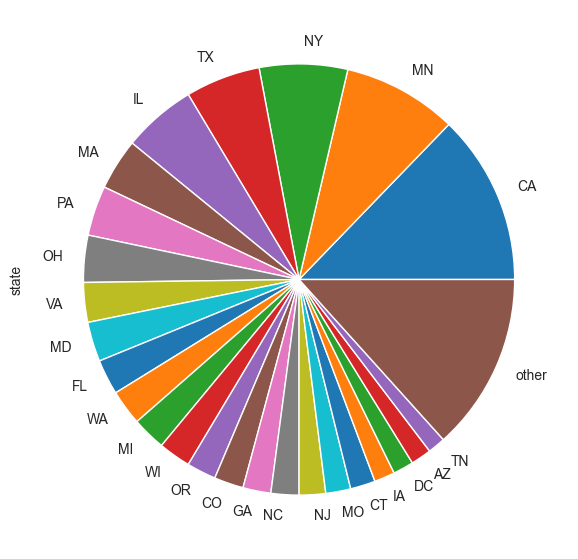

In [6]:
#print('Number of distinct Zipcodes:', df_all.zip_code.nunique())

users['zip_code'] = pd.to_numeric(users['zip_code'], errors='coerce')
users.dropna(inplace = True)
users['zip_code'] = users['zip_code'].astype('int64')
users_zips_n_states = pd.merge(users, zip_codes_df, on= "zip_code")
#print(len(users['zip_code']))
print('Number of distinct States or Territories:', users_zips_n_states.state.nunique())
users_states = users_zips_n_states['state'].value_counts().to_frame()

u_s_shrinked = users_states[:25].copy()
u_s_shrinked.loc['other'] = [users_states['state'][25:].sum()]
#print(u_s_shrinked.head())


user_state_flat = u_s_shrinked.transpose()
state_row = user_state_flat.iloc[0]
state_row.plot(kind='pie',figsize = (7,7), label = None)
u_states = users_zips_n_states.drop(['occupation','zip_code','gender','age',],axis=1)
df_all = pd.merge(df_proto,u_states,on= "user_id")

## Data Analysis on genres:

To get a better feeling on how the genre data looks, we need to have a look into the distribution of the genres from all movies. In the pie chart below, we can see that the most assigned genre is Drama and the second most assigned. So if we assume that the number of ratings indicate a number of views, we can say that Drama and Comedy are the most viewed genres.

C:\Users\hp\AppData\Local\Temp\ipykernel_3944\1312056352.py:10: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  genre_df.set_axis(genre_cols, axis='columns', inplace = True)


<AxesSubplot: ylabel='GENRE'>

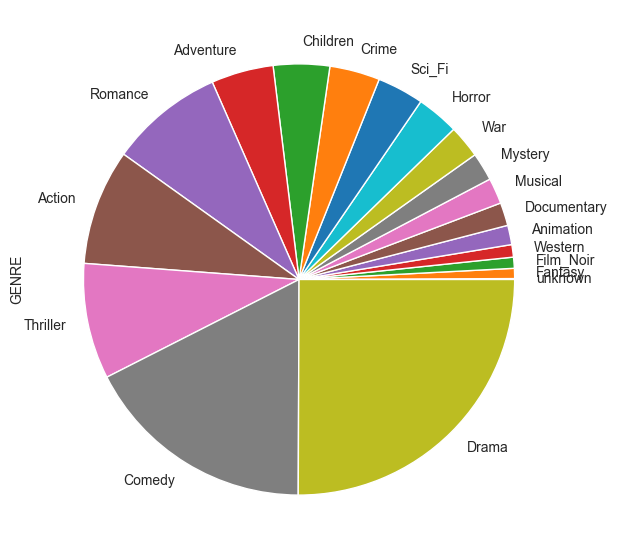

In [7]:
genre_cols = movie_cols[5:]
genre_series = [movies[genre] for genre in genre_cols]
#print(genre_cols)
#print(genre_series)
genre_sums = [series.sum() for series in genre_series]
#print(genre_sums)
genre_df = pd.DataFrame(genre_sums)
#print(genre_df)
genre_df = genre_df.transpose()
genre_df.set_axis(genre_cols, axis='columns', inplace = True)
genre_df['genre'] = 'GENRE'
genre_df.set_index('genre', inplace= True)
genre_df.sort_values(by='GENRE', axis=1, inplace= True)
#print(genre_df)
row = genre_df.iloc[0]
row.plot(kind='pie', figsize = (7,7))

## Data Analysis on movies:

The movies are quite differently often rated, ranging from 561 ratings on Star Wars to a single one on many less appreciated movies.
With a mean rating of 4.37, Star Wars is also the best rated Movie with over 300 ratings. (see output of second cell) So regarding the wide mass of all people, Star Wars will be suitable as a recommendated movie.

In [8]:
most_ratings = df_all.groupby(by = 'movie_title').size().sort_values(ascending=False)[:10]
least_ratings = df_all.groupby(by = 'movie_title').size().sort_values(ascending=True)[:10]
print(most_ratings)
print(least_ratings)

movie_title
Star Wars (1977)                 561
Contact (1997)                   492
Fargo (1996)                     489
Return of the Jedi (1983)        487
English Patient, The (1996)      468
Liar Liar (1997)                 467
Scream (1996)                    461
Toy Story (1995)                 435
Air Force One (1997)             417
Independence Day (ID4) (1996)    409
dtype: int64
movie_title
Á köldum klaka (Cold Fever) (1994)            1
Office Killer (1997)                          1
Object of My Affection, The (1998)            1
Normal Life (1996)                            1
Nobody Loves Me (Keiner liebt mich) (1994)    1
Niagara, Niagara (1997)                       1
New York Cop (1996)                           1
New Age, The (1994)                           1
Butterfly Kiss (1995)                         1
Nemesis 2: Nebula (1995)                      1
dtype: int64


In [9]:
movie_stats = df_all.groupby('movie_title').agg({'rating': [np.size, np.mean]}).sort_values([('rating', 'mean')], ascending=False)
#print(movie_stats)

atleast_300 = movie_stats['rating']['size'] >= 300
mov_s_300 = movie_stats[atleast_300].sort_values([('rating', 'mean')],ascending=False)
print(mov_s_300.head())

                                 rating          
                                   size      mean
movie_title                                      
Star Wars (1977)                    561  4.368984
Silence of the Lambs, The (1991)    375  4.290667
Godfather, The (1972)               395  4.273418
Raiders of the Lost Ark (1981)      402  4.253731
Titanic (1997)                      341  4.234604


In the following cell, the disribution of ages between the different users gets plotted, and the result is, that we can now see that most of the users are in an age group between 20 and 30, so the recommendations later will most likely be best suited for people this age because of the sheer mass of people.

Text(0.5, 0, 'age')

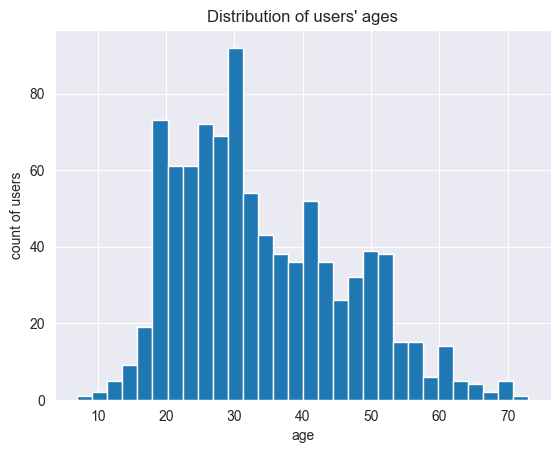

In [10]:
plt.figure()
sn.histplot(users['age'],bins = 30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age')

plt.hist(users['age'],bins=30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age')


Here we can add another attribute to our dataframe, which is the age put into groups.
Following this, the mean ratings depending on state get listed, so we can see which state is the meanest and which one is the nicest regarding the mean ratings for each state.
Also is it recognizable that the more ratings a group has, the nearer its mean reting is to the overall mean rating.

In [11]:
age_group_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
df_all['age_group'] = pd.cut(df_all.age, range(0, 81, 10), right=False, labels=age_group_labels)

df_all.groupby('state').agg({'rating': [np.size, np.mean]})

rating          
        size      mean
state                 
AE        21  3.428571
AK       437  3.496568
AL       248  3.858871
AP       105  3.200000
AR        26  3.384615
AZ      1463  3.400547
CA     13842  3.595506
CO      2389  3.467560
CT      1723  3.663378
DC      1411  3.530120
DE       110  3.172727
FL      1679  3.701013
GA      2317  3.513595
HI       298  3.503356
IA      1587  3.754883
ID      1801  3.462521
IL      5740  3.436063
IN      1006  3.639165
KS       406  3.995074
KY       962  3.408524
LA       698  3.593123
MA      2584  3.761223
MD      2739  3.255933
ME       123  4.170732
MI      2454  3.521597
MN      7635  3.497315
MO      2204  3.658802
MS       251  3.900398
MT       186  4.026882
NC      2008  3.532371
ND       231  3.138528
NE       528  3.751894
NH       915  3.786885
NJ      1702  3.505875
NM       574  3.592334
NV       266  3.657895
NY      6882  3.352078
OH      3475  3.526619
OK       962  3.594595
OR      1767  3.432937
PA      3339  3.565738
RI       429  3.461538
SC      1733  3.339296
SD        39  4.307692
TN      1206  3.716418
TX      5042  3.467672
UT       901  3.671476
VA      2590  3.444402
VT       431  3.580046
WA      2252  3.669627
WI      1785  3.755182
WV       116  4.586207
WY        48  3.500000

Now following we have a look at the 30 most rated movies and their ratings distributed onto the age groups, so it is checkable which age group liked which movie the most. Concluding it is important which age group a person is in to determine which movie he or she may like.

In [12]:
df_all.reset_index(inplace=True)
df_all.set_index('movie_title', inplace=True)
grouped_by_age = df_all.loc[most_ratings.index].groupby(['movie_title', 'age_group'])
grouped_by_age = grouped_by_age.rating.mean().unstack(1).fillna(0)
print(grouped_by_age)

age_group                      0-9     10-19     20-29     30-39     40-49  \
movie_title                                                                  
Air Force One (1997)           0.0  3.666667  3.668874  3.597826  3.550000   
Contact (1997)                 5.0  3.687500  3.789474  3.872727  3.876404   
English Patient, The (1996)    5.0  3.739130  3.604478  3.637931  3.637255   
Fargo (1996)                   0.0  3.967742  4.000000  4.232000  4.308642   
Independence Day (ID4) (1996)  0.0  3.634146  3.284024  3.423077  3.786885   
Liar Liar (1997)               4.0  3.191489  3.317460  3.035398  2.885714   
Return of the Jedi (1983)      4.0  4.500000  4.070000  3.795276  4.028571   
Scream (1996)                  0.0  3.796875  3.650485  3.284211  2.766667   
Star Wars (1977)               3.0  4.644444  4.405405  4.331081  4.195402   
Toy Story (1995)               0.0  3.666667  3.944751  4.043103  3.695652   

age_group                         50-59     60-69  70-79  
movi

In this Cell, the distribution is made regarding the gender of each user. When we compare the values between male and female, it is quite obvious, that gender is a main factor for the model, because the ratings differ dramatically.

In [13]:
df_all.reset_index(inplace=True)
df_all.set_index('movie_title', inplace=True)

pivoted = df_all.pivot_table(index=['movie_title'],
                           columns=['gender'],
                           values='rating',
                           fill_value=0)
pivoted.sort_values(by='F', inplace=True, ascending=False)
print(pivoted.head(10))
pivoted.sort_values(by='M', inplace=True, ascending=False)
print(pivoted.head(10))

gender                                   F         M
movie_title                                         
Best Men (1997)                        5.0  3.000000
Night Flier (1997)                     5.0  3.600000
Turbo: A Power Rangers Movie (1997)    5.0  1.000000
Year of the Horse (1997)               5.0  3.000000
Telling Lies in America (1997)         5.0  3.083333
Angel Baby (1995)                      5.0  3.000000
Prefontaine (1997)                     5.0  5.000000
Stripes (1981)                         5.0  3.500000
Visitors, The (Visiteurs, Les) (1993)  5.0  2.000000
Letter From Death Row, A (1998)        5.0  5.000000
gender                                               F    M
movie_title                                                
Entertaining Angels: The Dorothy Day Story (1996)  0.0  5.0
Anna (1996)                                        0.0  5.0
Leading Man, The (1996)                            2.5  5.0
Little City (1998)                                 2.0  5.0
Toug

In [14]:
df_all.head()

,index,movie_id,release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Thriller,War,Western,user_id,rating,age,gender,occupation,state,age_group
movie_title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0,1,1995.0,False,False,False,True,True,True,False,...,False,False,False,308,4,60,M,retired,CA,60-69
Get Shorty (1995),1,4,1995.0,False,True,False,False,False,True,False,...,False,False,False,308,5,60,M,retired,CA,60-69
Copycat (1995),2,5,1995.0,False,False,False,False,False,False,True,...,True,False,False,308,4,60,M,retired,CA,60-69
Twelve Monkeys (1995),3,7,1995.0,False,False,False,False,False,False,False,...,False,False,False,308,4,60,M,retired,CA,60-69
Babe (1995),4,8,1995.0,False,False,False,False,True,True,False,...,False,False,False,308,5,60,M,retired,CA,60-69


## Preprocessing
In the following cell we start our preprocessing to fit our data into the model(s). First step is encoding the data, so it can be better processed.

In [20]:
user_enc = LabelEncoder()
df_all['user_enc'] = user_enc.fit_transform(df_all['user_id'].values)

item_enc = LabelEncoder()
df_all['movie_enc'] = item_enc.fit_transform(df_all['movie_id'].values)

gender_enc = LabelEncoder()
df_all['gen_enc'] =  gender_enc.fit_transform(df_all['gender'].values)

age_enco = LabelEncoder()
df_all['age_enc'] =  age_enco.fit_transform(df_all['age_group'].values)

occupation_enc = LabelEncoder()
df_all['occ_enc'] =  occupation_enc.fit_transform(df_all['occupation'].values)

state_enc = LabelEncoder()
df_all['sta_enc'] =  state_enc.fit_transform(df_all['state'].values)

df_all['rating'] = df_all['rating'].values.astype(np.float32)

n_movies = df_all['movie_enc'].nunique()
n_users = df_all['user_enc'].nunique()
min_rating = min(df_all['rating'])
max_rating = max(df_all['rating'])

To fit out network(s) later on, we will have to split our data into x and y, and into training and test sets. The test sets will contain 10 percent of all datapoints.

In [21]:
X = df_all[['user_enc', 'movie_enc', 'gen_enc', 'age_enc', 'occ_enc', 'sta_enc']].values
y = df_all['rating'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((86099, 6), (9567, 6), (86099,), (9567,))

In [22]:
n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], X_train[:, 4], X_train[:, 5]]
X_val_array = [X_val[:, 0], X_val[:, 1], X_val[:, 2], X_val[:, 3], X_val[:, 4], X_val[:, 5]]

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Add, Activation, Lambda

The following model is taken from https://step.recohut.com/codelabs/movie-recommender-using-keras/, because is has been already designed to be suitable for movie recommendation using the concept of collaborative filtering. However they have to be slightly changed, so the additional info can be fed into the network.

In [24]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors

    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def Recommender(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)

    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)

    gender = Input(shape=(1,))
    g = EmbeddingLayer(n_movies, n_factors)(gender)
    gb = EmbeddingLayer(n_movies, 1)(gender)

    age = Input(shape=(1,))
    a = EmbeddingLayer(n_movies, n_factors)(age)
    ab = EmbeddingLayer(n_movies, 1)(age)

    occu = Input(shape=(1,))
    o = EmbeddingLayer(n_movies, n_factors)(occu)
    ob = EmbeddingLayer(n_movies, 1)(occu)

    state = Input(shape=(1,))
    s = EmbeddingLayer(n_movies, n_factors)(state)
    sb = EmbeddingLayer(n_movies, 1)(state)

    x0 = Dot(axes=1)([u, m])
    x1 = Dot(axes=1)([g, a])
    x2 = Dot(axes=1)([o, s])
    x3 = Dot(axes=1)([x0, x1])
    x = Dot(axes=1)([x2, x3])
    x = Add()([x, ub, mb, gb, ab, ob, sb])
    x = Activation('sigmoid')(x)
    x_out = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    model = Model(inputs=[user, movie, gender, age, occu, state], outputs=x_out)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model

In [25]:
model = Recommender(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

Up above we have our complete model as an outline, and now in the following cell we can train it with the training and validation data.

In [26]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=15,
                    verbose=1, validation_data=(X_val_array, y_val))

Epoch 1/20
1346/1346 [==============================] - 10s 4ms/step - loss: 1.1700 - val_loss: 1.0680
Epoch 2/20
1346/1346 [==============================] - 6s 4ms/step - loss: 1.0189 - val_loss: 0.9874
Epoch 3/20
1346/1346 [==============================] - 6s 4ms/step - loss: 0.9517 - val_loss: 0.9468
Epoch 4/20
1346/1346 [==============================] - 5s 4ms/step - loss: 0.9143 - val_loss: 0.9232
Epoch 5/20
1346/1346 [==============================] - 6s 4ms/step - loss: 0.8916 - val_loss: 0.9086
Epoch 6/20
1346/1346 [==============================] - 6s 4ms/step - loss: 0.8768 - val_loss: 0.9002
Epoch 7/20
1346/1346 [==============================] - 7s 5ms/step - loss: 0.8666 - val_loss: 0.8941
Epoch 8/20
1346/1346 [==============================] - 7s 5ms/step - loss: 0.8594 - val_loss: 0.8895
Epoch 9/20
1346/1346 [==============================] - 7s 5ms/step - loss: 0.8540 - val_loss: 0.8864
Epoch 10/20
1346/1346 [==============================] - 8s 6ms/step - loss: 0.85

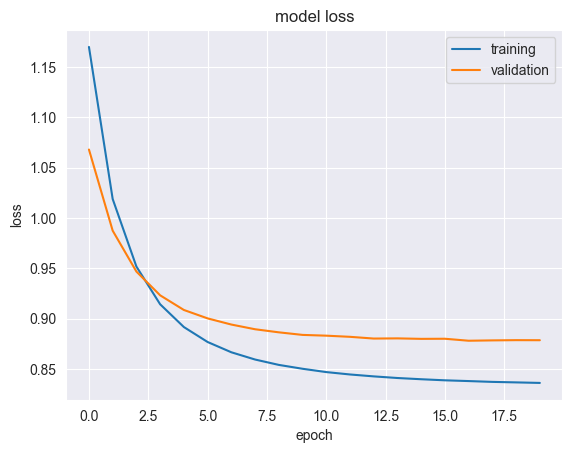

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["training", "validation"], loc="upper right")
plt.show()

And now finally we can show our recommendated rating for a certain user with given attributes and a movie:

In [28]:
my_user_id = df_all.user_id.sample(1).iloc[0]
user = df_all.loc[df_all['user_id'] == my_user_id, 'user_enc'].iloc[0]
gender = df_all.loc[df_all['user_id'] == my_user_id, 'gen_enc'].iloc[0]
age = df_all.loc[df_all['user_id'] == my_user_id, 'age_enc'].iloc[0]
occupation = df_all.loc[df_all['user_id'] == my_user_id, 'occ_enc'].iloc[0]
state = df_all.loc[df_all['user_id'] == my_user_id, 'sta_enc'].iloc[0]
# print(my_user_id,user, gender, age, occupation, state)

movie = movies.movie_id.sample(random_state=np.random.default_rng()).iloc[0]
movie_title = movies.loc[movies['movie_id'] == movie, 'movie_title'].iloc[0]
print("Showing recommended rating for user: ", my_user_id, " on Movie:", movie_title)
print("====" * 25)
prediction = model.predict((np.array([user]),np.array([movie]),np.array([gender]),np.array([age]), np.array([occupation]), np.array([state])),verbose=0)
print("Predicted Score: ", prediction)

Showing recommended rating for user:  465  on Movie: Interview with the Vampire (1994)
Predicted Score:  [[2.0690012]]
